##### Copyright 2019 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Keras 前処理レイヤーを使って構造化データを分類する

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">    TensorFlow.org で表示</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/structured_data/preprocessing_layers.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">    Google Colab で実行</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/structured_data/preprocessing_layers.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">    GitHub でソースを表示</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/structured_data/preprocessing_layers.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a>   </td>
</table>

このチュートリアルでは、CSV ファイルに保存されている <a href="https://www.kaggle.com/c/petfinder-adoption-prediction" class="external"> Kaggle コンペティションの PetFinder データセット</a>の簡略版を使用して、表形式のデータなど構造化データを分類する方法を示します。

[Keras](https://www.tensorflow.org/guide/keras) を使用してモデルを定義し、[Keras 前処理レイヤー](https://www.tensorflow.org/guide/keras/preprocessing_layers)を CSV ファイルの列からモデルのトレーニングに使用される特徴量にマッピングするためのブリッジとして使用します。目標は、ペットが引き取られるかどうかを予測することです。

このチュートリアルには、次の完全なコードが含まれています。

- <a href="https://pandas.pydata.org/" class="external">pandas</a> を使用して、CSV ファイルを <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">DataFrame</a> に読み込む。
- `tf.data` を使用して、行をバッチ処理およびシャッフルするための入力パイプラインを構築する。 (詳細については、[tf.data: TensorFlow 入力パイプラインの構築](../../guide/data.ipynb)を参照してください。)
- Keras 前処理レイヤーを使ってモデルをトレーニングするために使用する特徴量に、CSV のカラムをマッピングする。
- Keras の組み込みメソッドを使用してモデルを構築、トレーニング、および評価する。

注意: このチュートリアルは、「[特徴量カラムを使って構造化データを分類する](../structured_data/feature_columns.ipynb)」に類似しています。このバージョンでは、[Keras 前処理レイヤー](https://www.tensorflow.org/guide/keras/preprocessing_layers)を使用しており、`tf.feature_column` API を使っていません。Keras 前処理レイヤーはより直感的であり、デプロイを単純化するようにモデル内に簡単に含めることができます。

## PetFinder.my mini データセット

PetFinder.my mini の CSV データセットファイルには数千の行があり、各行はペット (犬または猫) を表し、各列は年齢、品種、色などの属性を表します。

以下のデータセットの要約では、ほとんどが数値カラムとカテゴリカルカラムであることに注意してください。このチュートリアルでは、データの前処理中に `Description` (フリーテキスト特徴量) と `AdoptionSpeed` (分類特徴量) を削除し、これら 2 つの特徴量の型のみを扱います。

カラム | ペットの説明 | 特徴量の型 | データ型
--- | --- | --- | ---
`Type` | 動物の種類（犬、猫） | カテゴリカル | 文字列
`Age` | 年齢 | 数値 | 整数
`Breed1` | 主な品種 | カテゴリカル | 文字列
`Color1` | Color1 | カテゴリカル | 文字列
`Color2` | Color2 | カテゴリカル | 文字列
`MaturitySize` | 成獣時のサイズ | カテゴリカル | 文字列
`FurLength` | 毛の長さ | カテゴリカル | 文字列
`Vaccinated` | 予防接種済み | カテゴリカル | 文字列
`Sterilized` | 不妊手術済み | カテゴリカル | 文字列
`Health` | 健康状態 | カテゴリカル | 文字列
`Fee` | 引き取り料 | 数値 | 整数
`説明` | プロファイルの記述 | テキスト | 文字列
`PhotoAmt` | アップロードされたペットの写真数 | 数値 | 整数
`AdoptionSpeed` | 引き取りまでの期間 (カテゴリカル) | 分類 | 整数

## TensorFlow とその他のライブラリをインポートする


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

2022-12-14 23:01:13.640681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:01:13.640779: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:01:13.640789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
tf.__version__

'2.11.0'

## データセットを読み込み、pandas DataFrame に読み込む

<a href="https://pandas.pydata.org/" class="external">Pandas</a> は、構造化データの読み込みと処理を支援するユーティリティが多数含まれる Python ライブラリです。`tf.keras.utils.get_file` を使用して、PetFinder.my mini データセットを含む CSV ファイルをダウンロードして抽出し、<a href="https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html" class="external"><code>pandas.read_csv</code></a> を使用して <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">DataFrame</a> に読み込みます。

In [4]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

   8192/1668792 [..............................] - ETA: 0s

1668792/1668792 [==============================] - 0s 0us/step


DataFrame の最初の 5 行をチェックして、データセットを確認します。

In [5]:
dataframe.head()

Type  Age                Breed1  Gender Color1    Color2 MaturitySize  \
0  Cat    3                 Tabby    Male  Black     White        Small   
1  Cat    1  Domestic Medium Hair    Male  Black     Brown       Medium   
2  Dog    1           Mixed Breed    Male  Brown     White       Medium   
3  Dog    4           Mixed Breed  Female  Black     Brown       Medium   
4  Dog    1           Mixed Breed    Male  Black  No Color       Medium   

  FurLength Vaccinated Sterilized   Health  Fee  \
0     Short         No         No  Healthy  100   
1    Medium   Not Sure   Not Sure  Healthy    0   
2    Medium        Yes         No  Healthy    0   
3     Short        Yes         No  Healthy  150   
4     Short         No         No  Healthy    0   

                                         Description  PhotoAmt  AdoptionSpeed  
0  Nibble is a 3+ month old ball of cuteness. He ...         1              2  
1  I just found it alone yesterday near my apartm...         2              0  
2  Their pregnant mother was dumped by her irresp...         7              3  
3  Good guard dog, very alert, active, obedience ...         8              2  
4  This handsome yet cute boy is up for adoption....         3              2

## ターゲット変数を作成する

Kaggle の <a href="https://www.kaggle.com/c/petfinder-adoption-prediction" class="external">PetFinder.my 養子縁組予測コンペティション</a>の元のタスクは、ペットが引き取られるまでの期間を予測することでした (一週間、1 か月、3か月など) 。

このチュートリアルでは、ペットが引き取られるかどうかを予測するだけのバイナリ分類問題に変換することで、タスクを簡略化します。

`AdoptionSpeed` を変更し、`0` は引き取られなかった、`1` は引き取られたことを示すようになります。

In [6]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

## DataFrame をトレーニング、検証、およびテストセットに分割する

データセットは単一の pandas DataFrame にあります。たとえば、80:10:10 の比率を使用して、トレーニング、検証、およびテストセットに分割します。

In [7]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [8]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


## tf.data を使用して入力パイプラインを作成する

次に、トレーニング、検証、テストセットの DataFrame をそれぞれ `tf.data.Dataset` に変換するユーティリティ関数を作成し、データをシャッフルしてバッチ処理します。

注意: 非常に大型 (メモリに収まらないほどの規模) の CSV ファイルを処理する場合は、`tf.data` API を使用してディスクから直接読み取ります。この方法は、このチュートリアルでは取り上げられていません。

In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

次に、新しく作成された関数 (`df_to_dataset`) を使用して、入力パイプラインヘルパー関数がトレーニングデータで呼び出すことによって返すデータの形式を確認し、小さなバッチサイズを使用して出力を読み取り可能に保ちます。

In [10]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/tmpfs/tmp/ipykernel_129418/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [11]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor(
[[36]
 [ 3]
 [ 4]
 [12]
 [ 3]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 0 1 0 1], shape=(5,), dtype=int64)


出力が示すように、トレーニングセットは、行のカラム値にマップされる (DataFrame からの) カラム名のディクショナリを返します。

## Keras 前処理レイヤーを適用する

Keras 前処理レイヤーを使用すると、Keras ネイティブの入力処理パイプラインを構築できます。これらの入力処理パイプラインは、Keras 以外のワークフローで独立した前処理コードとして使用し、Keras モデルと直接組み合わせて、Keras SavedModel の一部としてエクスポートできます。

このチュートリアルでは、次の 4 つの前処理レイヤーを使用して、前処理、構造化データエンコーディング、および特徴量エンジニアリングを実行する方法を示します。

- `tf.keras.layers.Normalization`: 入力した特徴量を特徴量ごとに正規化します。
- `tf.keras.layers.CategoryEncoding`: 整数のカテゴリカル特徴量をワンホット、マルチホット、または <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" class="external">tf-idf</a> デンス表現に変換します。
- `tf.keras.layers.StringLookup`: 文字列のカテゴリ値を整数インデックスに変換します。
- `tf.keras.layers.IntegerLookup`: 整数のカテゴリ値を整数のインデックスに変換します。

使用可能なレイヤーの詳細については、[前処理レイヤーの使用](https://www.tensorflow.org/guide/keras/preprocessing_layers)ガイドを参照してください。

- PetFinder.my mini データセットの*数値特徴量*の場合、`tf.keras.layers.Normalization` レイヤーを使用してデータの分布を標準化します。
- ペット`Type` (`Dog` 、`Cat` 文字列)などの*カテゴリカル特徴量*の場合、`tf.keras.layers.CategoryEncoding`  でそれらをマルチホットエンコードされたテンソルに変換します。

### 数値カラム

PetFinder.my mini データセットの数値特徴量の場合、<code>tf.keras.layers.Normalization</code> レイヤーを使用してデータの分布を標準化します。

Keras 前処理レイヤーを使用して、数値特徴量の特徴ごとに正規化を適用するレイヤーを返す新しいユーティリティ関数を定義します。

In [12]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

次に、アップロードされたペットの写真特徴量の合計で新しい関数を呼び出して、`'PhotoAmt'` を正規化して新しい関数をテストします。

In [13]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.19220197],
       [ 0.44610238],
       [-0.19220197],
       [ 0.44610238],
       [-0.51135415]], dtype=float32)>

注意: 多数の数値特徴量 (数百個以上) がある場合は、先にそれらを連結してから単一の `tf.keras.layers.Normalization` レイヤーを使用するとより効率的です。

### カテゴリカルカラム

データセット内のペットの `Type` は、文字列（`Dog`、`Cat`) として表されます。これらは、フィードする前にマルチホットエンコードする必要があります。

`tf.keras.layers.StringLookup`、 `tf.keras.layers.IntegerLookup`、`tf.keras.CategoryEncoding` 前処理レイヤーを使用して語彙から整数インデックスに値をマップし、特徴量をマルチホットエンコードするレイヤーを返す別の新しいユーティリティ関数を定義します

In [14]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

ペットの `'Type'` 特徴量で呼び出して `get_category_encoding_layer` 関数をテストし、マルチホットエンコードされたテンソルに変換します。

In [15]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

ペットの `'Age'` 特徴量でこのプロセスを繰り返します。

In [16]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>

## 選択した特徴量を前処理して、モデルをトレーニングする

いくつかの Keras 前処理レイヤーの使用方法を学びました。次に、以下を行います。

- PetFinder.my mini データセットの 13 の数値特徴量とカテゴリカル特徴量で前に定義した前処理ユーティリティ関数を適用します。
- すべての特徴量の入力をリストに追加します。

冒頭で述べたように、モデルをトレーニングするには、PetFinder.my mini データセットの数値特徴量(`'PhotoAmt'`、`'Fee'`) とカテゴリカル特徴量 (`'Age'`、`'Type'`、`'Color1'`、`'Color2'`、`'Gender'`、`'MaturitySize'`、`'FurLength'`、`'Vaccinated'`、`'Sterilized'`、`'Health'`、`'Breed1'`) を使用します。

重要: 正確なモデルの構築を目的としている場合は、より大きなデータセットを独自に用意し、どの特徴量が最も有意義で、どのように表現するべきかについて検討しましょう。

前に、入力パイプラインを実演するために小さなバッチを使用しました。今度はより大きなバッチサイズ (256) で新しい入力パイプラインを作成してみましょう。

In [17]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmpfs/tmp/ipykernel_129418/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmpfs/tmp/ipykernel_129418/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmpfs/tmp/ipykernel_129418/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


数値の特徴量 (ペットの写真の数と引き取り料金) を正規化し、`encoded_features` と呼ばれる入力の 1 つのリストに追加します。

In [18]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

データセット (ペットの年齢) からの整数カテゴリカル値を整数インデックスに変換し、マルチホットエンコーディングを実行して、結果の特徴量入力を `encoded_features` に追加します。

In [19]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

文字列のカテゴリカル値に対して同じ手順を繰り返します。

In [20]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

## モデルを作成、コンパイル、およびトレーニングする


次のステップは、[Keras Functional API](https://www.tensorflow.org/guide/keras/functional) を使用してモデルを作成することです。モデルの最初のレイヤーでは、`tf.keras.layers.concatenate` との連結により、特徴量入力のリスト (`encoded_features`) を 1 つのベクトルにマージします。

In [21]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

Keras `Model.compile` を使用してモデルを構成します。

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

接続性グラフを視覚化しましょう。


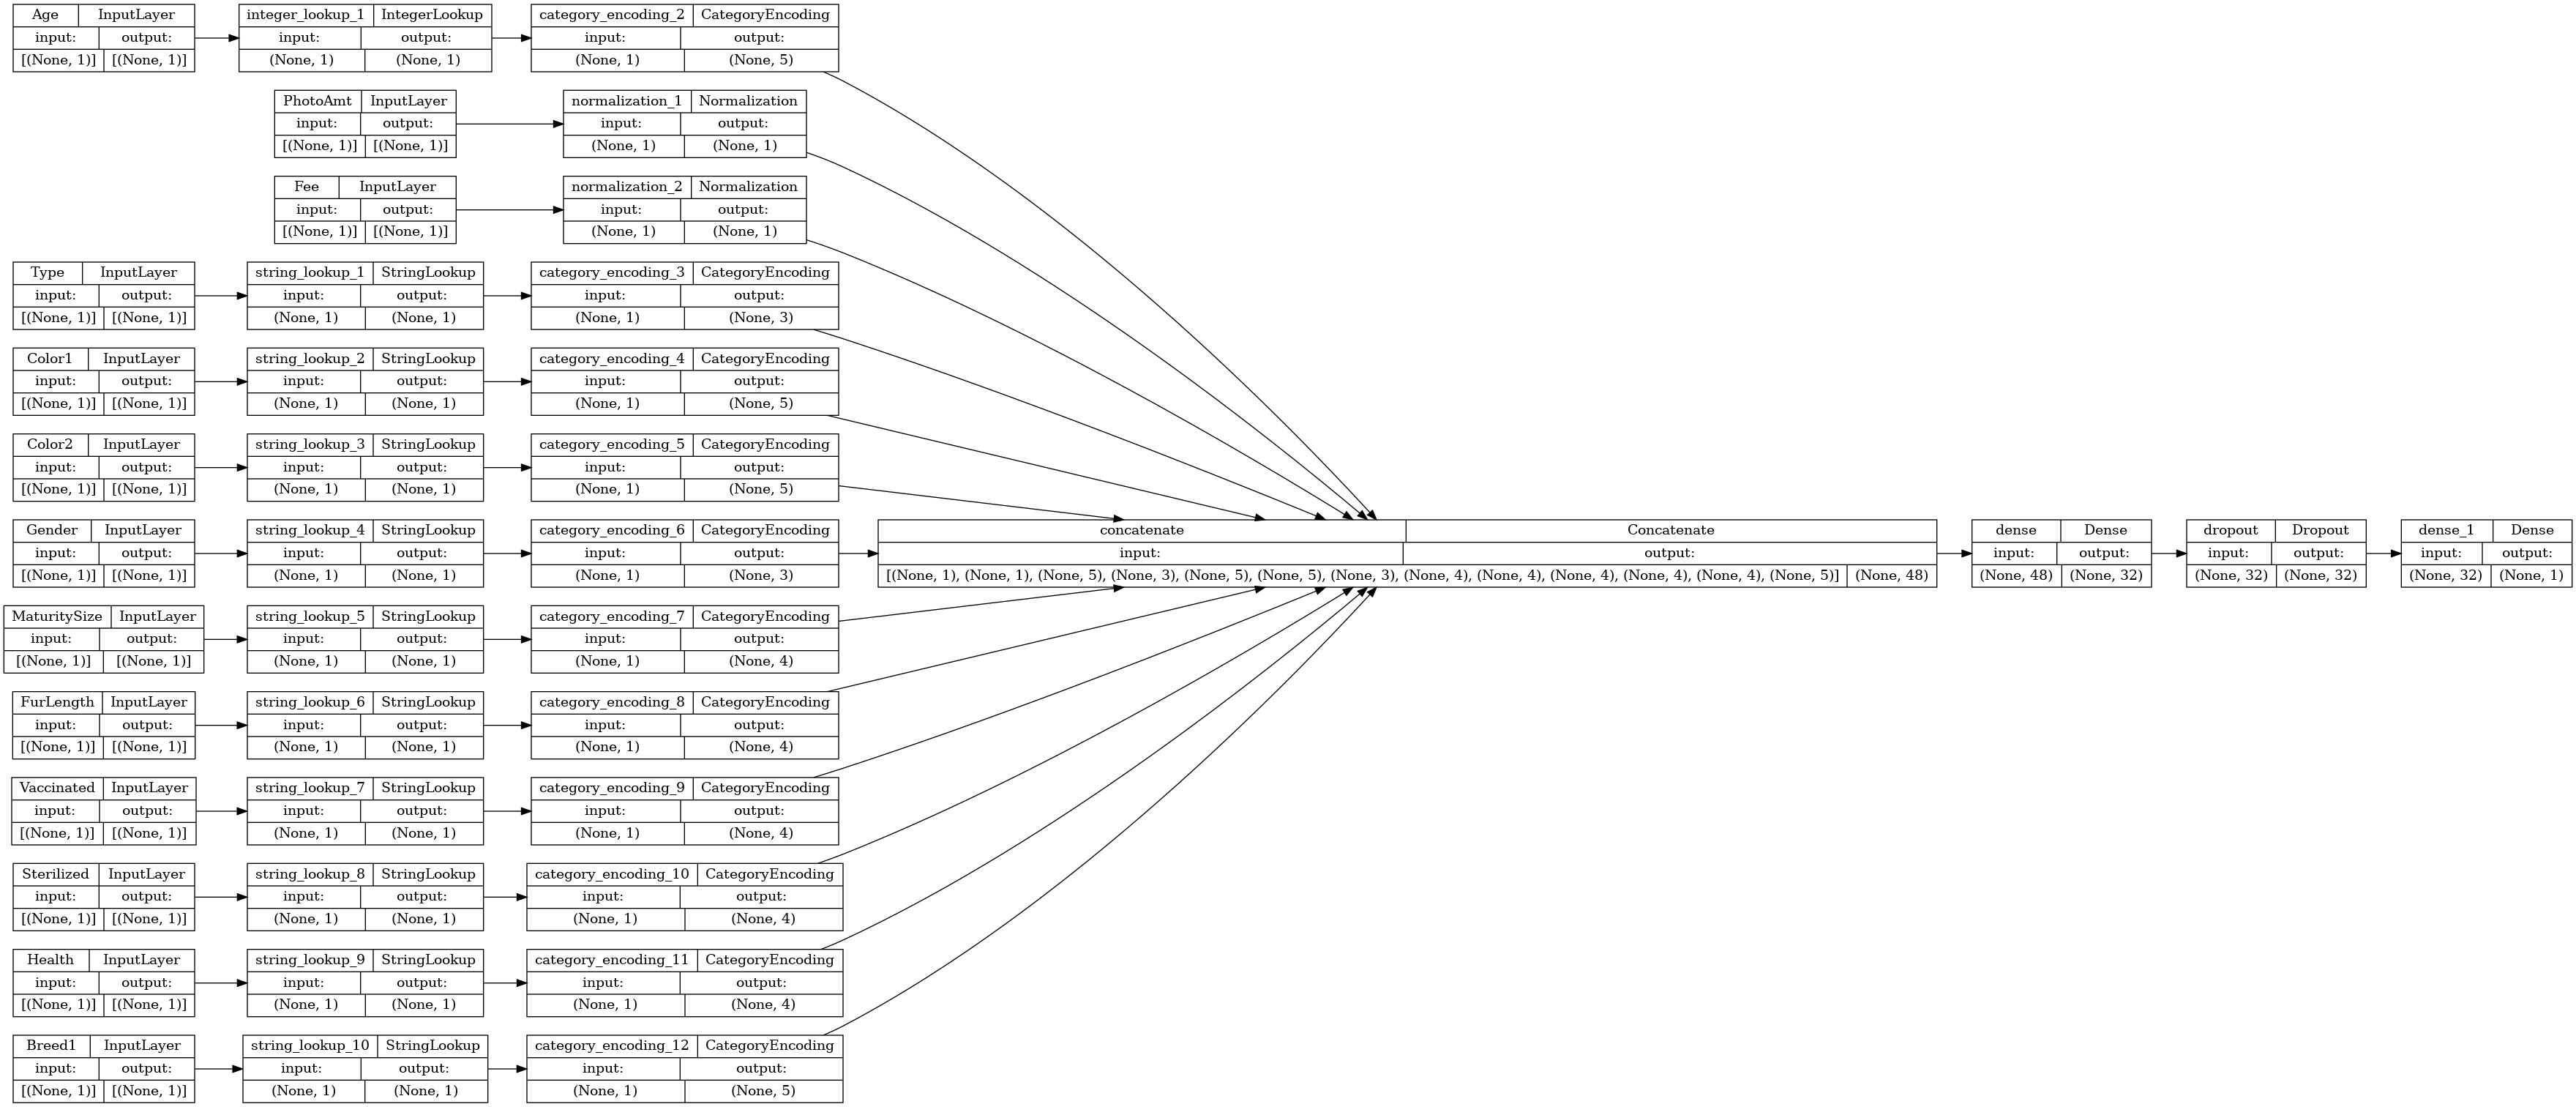

In [23]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

次に、モデルをトレーニングし、テストします。

In [24]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/37 [..............................] - ETA: 1:08 - loss: 0.6540 - accuracy: 0.4766

10/37 [=======>......................] - ETA: 0s - loss: 0.6861 - accuracy: 0.4621  

20/37 [===============>..............] - ETA: 0s - loss: 0.6687 - accuracy: 0.5125

29/37 [======================>.......] - ETA: 0s - loss: 0.6488 - accuracy: 0.5524

37/37 [==============================] - 3s 19ms/step - loss: 0.6446 - accuracy: 0.5707 - val_loss: 0.6106 - val_accuracy: 0.7080


Epoch 2/10


 1/37 [..............................] - ETA: 2s - loss: 0.6151 - accuracy: 0.6445

10/37 [=======>......................] - ETA: 0s - loss: 0.6124 - accuracy: 0.6523

19/37 [==============>...............] - ETA: 0s - loss: 0.5955 - accuracy: 0.6614

28/37 [=====================>........] - ETA: 0s - loss: 0.5926 - accuracy: 0.6635

37/37 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.6678

37/37 [==============================] - 0s 7ms/step - loss: 0.5891 - accuracy: 0.6678 - val_loss: 0.5740 - val_accuracy: 0.7244


Epoch 3/10


 1/37 [..............................] - ETA: 2s - loss: 0.6215 - accuracy: 0.6719

10/37 [=======>......................] - ETA: 0s - loss: 0.5803 - accuracy: 0.6809

19/37 [==============>...............] - ETA: 0s - loss: 0.5682 - accuracy: 0.6926

28/37 [=====================>........] - ETA: 0s - loss: 0.5703 - accuracy: 0.6941

37/37 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.6930

37/37 [==============================] - 0s 7ms/step - loss: 0.5709 - accuracy: 0.6930 - val_loss: 0.5551 - val_accuracy: 0.7383


Epoch 4/10


 1/37 [..............................] - ETA: 2s - loss: 0.5227 - accuracy: 0.7070

10/37 [=======>......................] - ETA: 0s - loss: 0.5582 - accuracy: 0.6891

19/37 [==============>...............] - ETA: 0s - loss: 0.5579 - accuracy: 0.6881

28/37 [=====================>........] - ETA: 0s - loss: 0.5556 - accuracy: 0.6960

37/37 [==============================] - ETA: 0s - loss: 0.5550 - accuracy: 0.6983

37/37 [==============================] - 0s 7ms/step - loss: 0.5550 - accuracy: 0.6983 - val_loss: 0.5454 - val_accuracy: 0.7426


Epoch 5/10


 1/37 [..............................] - ETA: 2s - loss: 0.5413 - accuracy: 0.7305

10/37 [=======>......................] - ETA: 0s - loss: 0.5401 - accuracy: 0.7184

19/37 [==============>...............] - ETA: 0s - loss: 0.5414 - accuracy: 0.7175

28/37 [=====================>........] - ETA: 0s - loss: 0.5416 - accuracy: 0.7181

37/37 [==============================] - 0s 7ms/step - loss: 0.5438 - accuracy: 0.7147 - val_loss: 0.5380 - val_accuracy: 0.7444


Epoch 6/10


 1/37 [..............................] - ETA: 2s - loss: 0.5607 - accuracy: 0.6680

10/37 [=======>......................] - ETA: 0s - loss: 0.5379 - accuracy: 0.6957

19/37 [==============>...............] - ETA: 0s - loss: 0.5380 - accuracy: 0.7046

28/37 [=====================>........] - ETA: 0s - loss: 0.5375 - accuracy: 0.7073

37/37 [==============================] - ETA: 0s - loss: 0.5370 - accuracy: 0.7105

37/37 [==============================] - 0s 7ms/step - loss: 0.5370 - accuracy: 0.7105 - val_loss: 0.5334 - val_accuracy: 0.7461


Epoch 7/10


 1/37 [..............................] - ETA: 2s - loss: 0.4894 - accuracy: 0.7148

10/37 [=======>......................] - ETA: 0s - loss: 0.5313 - accuracy: 0.7250

19/37 [==============>...............] - ETA: 0s - loss: 0.5319 - accuracy: 0.7280

28/37 [=====================>........] - ETA: 0s - loss: 0.5340 - accuracy: 0.7239

37/37 [==============================] - 0s 7ms/step - loss: 0.5327 - accuracy: 0.7230 - val_loss: 0.5292 - val_accuracy: 0.7461


Epoch 8/10


 1/37 [..............................] - ETA: 2s - loss: 0.5078 - accuracy: 0.7734

10/37 [=======>......................] - ETA: 0s - loss: 0.5370 - accuracy: 0.7238

19/37 [==============>...............] - ETA: 0s - loss: 0.5305 - accuracy: 0.7155

28/37 [=====================>........] - ETA: 0s - loss: 0.5307 - accuracy: 0.7192

37/37 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.7217

37/37 [==============================] - 0s 7ms/step - loss: 0.5274 - accuracy: 0.7217 - val_loss: 0.5283 - val_accuracy: 0.7470


Epoch 9/10


 1/37 [..............................] - ETA: 2s - loss: 0.5425 - accuracy: 0.6641

10/37 [=======>......................] - ETA: 0s - loss: 0.5236 - accuracy: 0.7238

19/37 [==============>...............] - ETA: 0s - loss: 0.5289 - accuracy: 0.7216

28/37 [=====================>........] - ETA: 0s - loss: 0.5265 - accuracy: 0.7266

37/37 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.7224

37/37 [==============================] - 0s 7ms/step - loss: 0.5270 - accuracy: 0.7224 - val_loss: 0.5248 - val_accuracy: 0.7470


Epoch 10/10


 1/37 [..............................] - ETA: 2s - loss: 0.4909 - accuracy: 0.7461

10/37 [=======>......................] - ETA: 0s - loss: 0.5171 - accuracy: 0.7480

19/37 [==============>...............] - ETA: 0s - loss: 0.5230 - accuracy: 0.7385

28/37 [=====================>........] - ETA: 0s - loss: 0.5249 - accuracy: 0.7348

37/37 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.7368

37/37 [==============================] - 0s 7ms/step - loss: 0.5203 - accuracy: 0.7368 - val_loss: 0.5223 - val_accuracy: 0.7470


In [25]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1/5 [=====>........................] - ETA: 0s - loss: 0.5299 - accuracy: 0.7383

5/5 [==============================] - 0s 5ms/step - loss: 0.4998 - accuracy: 0.7539


Accuracy 0.7538994550704956


## 推論を実行する

開発したモデルには前処理コードが含まれているため、直接 CSV ファイルから行を分類できるようになりました。

新しいデータで推論を実行する前に、`Model.save` と `Model.load_model` で[ Keras モデル保存して再読み込み](../keras/save_and_load.ipynb)できるようになりました。

In [26]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier/assets


INFO:tensorflow:Assets written to: my_pet_classifier/assets


Keras `model.predict` メソッドを呼び出すだけで、新しいサンプルの予測を得ることができます。後は、次を実行するだけです。

1. バッチに次元を持たせるために、スカラーをリストにラップします (`Model` は、単一のサンプルではなく、データのバッチのみを処理します)。
2. 各特徴量で `tf.convert_to_tensor` を呼び出します。

In [27]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 421ms/step


This particular pet had a 77.6 percent probability of getting adopted.


注意: 通常、データベースの規模が大きく複雑であるほど、ディープラーニングの結果がよくなります。簡易化された PetFinder.my のデータセットのように、小さなデータセットを使用する場合は、<a href="https://developers.google.com/machine-learning/glossary#decision-tree" class="external">決定木</a>または<a href="https://developers.google.com/machine-learning/glossary#random-forest" class="external">ランダムフォレスト</a>を強力なベースラインとして使用することをお勧めします。このチュートリアルでは、構造化データとの連携の仕組みを実演することが目的であり、将来的に独自のデータセットを使用する際の出発点として使用してください。


## 次のステップ

構造化データの分類についてさらに学ぶには、他のデータセットを使用してみてください。モデルのトレーニングおよびテスト中の精度を向上させるには、モデルに含める特徴量とそれらをどのように表現するかを慎重に検討してください。

以下は、データセットに関するいくつかの提案です。

- [TensorFlow Datasets: MovieLens](https://www.tensorflow.org/datasets/catalog/movie_lens): 映画推薦サービスからの映画レビューのセット。
- [TensorFlow Datasets: ワインの品質](https://www.tensorflow.org/datasets/catalog/wine_quality): ポルトガルの「ヴィーニョヴェルデ」赤ワインと白ワインの 2 つのデータセット。赤ワインの品質データセットは <a href="https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009" class="external">Kaggle</a> にもあります。
- <a href="https://www.kaggle.com/Cornell-University/arxiv" class="external">Kaggle: arXiv Dataset</a>: 物理学、コンピューターサイエンス、数学、統計学、電気工学、量的生物学、および経済学を含む、arXiv からの 170 万の学術論文のコーパス。
